In [1]:
# bring in dataset of monthly stock returns
import numpy as np
import datetime as dt
import pandas as pd
dsp=pd.read_csv('DailyStockPrice.csv', parse_dates=['date'])
dsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554406 entries, 0 to 554405
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    554406 non-null  datetime64[ns]
 1   TICKER  552207 non-null  object        
 2   RETX    552151 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 12.7+ MB


In [2]:
dsp.head()

,date,TICKER,RETX
0,2016-01-04,ORCL,-0.02
1,2016-01-05,ORCL,0.00
2,2016-01-06,ORCL,0.01
3,2016-01-07,ORCL,-0.02
4,2016-01-08,ORCL,-0.01


In [3]:
from pandas.tseries.offsets import MonthBegin
from datetime import timedelta


In [4]:
fyear=pd.read_csv('FiscakYear.csv', parse_dates=['datadate'])

fyear['begdate'] = fyear['datadate']- timedelta(days=365) + MonthBegin(0)

fyear[['tic','fyear','begdate','datadate']].tail()

,tic,fyear,begdate,datadate
719,TSLA,2017,2017-01-01,2017-12-31
720,TSLA,2018,2018-01-01,2018-12-31
721,TSLA,2019,2019-01-01,2019-12-31
722,TSLA,2020,2020-01-01,2020-12-31
723,TSLA,2021,2021-01-01,2021-12-31


In [5]:
import sqlite3
sqlconn = sqlite3.connect(':memory:')
fyear.to_sql('fyear',sqlconn)
dsp.to_sql('dsp', sqlconn,)

qry = '''
     SELECT
    a.tic, a.fyear, a.begdate, a.datadate, b.date, b.RETX, b.TICKER
    FROM fyear as a 
    LEFT JOIN dsp as b
    ON a.tic = b.TICKER
    AND a.begdate <= b.date 
    AND b.date <= a.datadate
    ORDER BY tic, datadate, date
    '''

In [6]:
fyear_dsp = pd.read_sql_query(qry, sqlconn)

In [7]:
fyear_dsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176950 entries, 0 to 176949
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   tic       176950 non-null  object 
 1   fyear     176950 non-null  int64  
 2   begdate   176950 non-null  object 
 3   datadate  176950 non-null  object 
 4   date      176937 non-null  object 
 5   RETX      176932 non-null  float64
 6   TICKER    176937 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 9.5+ MB


In [8]:
fyear_dsp2=fyear_dsp.drop(columns=['tic'])

In [9]:
fyear_dsp2.head()

,fyear,begdate,datadate,date,RETX,TICKER
0,2016,2015-10-01 00:00:00,2016-09-30 00:00:00,2015-10-01 00:00:00,-0.01,AAPL
1,2016,2015-10-01 00:00:00,2016-09-30 00:00:00,2015-10-02 00:00:00,0.01,AAPL
2,2016,2015-10-01 00:00:00,2016-09-30 00:00:00,2015-10-05 00:00:00,0.00,AAPL
3,2016,2015-10-01 00:00:00,2016-09-30 00:00:00,2015-10-06 00:00:00,0.00,AAPL
4,2016,2015-10-01 00:00:00,2016-09-30 00:00:00,2015-10-07 00:00:00,0.00,AAPL


In [10]:
fyear_dsp3=fyear_dsp2.groupby(['TICKER','fyear'], as_index=False)['RETX'].mean()
fyear_dsp3.rename(columns={'RETX':'avg_prc', 'TICKER':'Ticker', 'fyear':'FiscalYear'}, inplace=True)
fyear_dsp3.tail(10)

,Ticker,FiscalYear,avg_prc
592,WMT,2018,-0.000279
593,WMT,2019,0.000873
594,WMT,2020,0.000956
595,WMT,2021,-0.000158
596,XOM,2016,0.000675
597,XOM,2017,-0.000359
598,XOM,2018,-0.000876
599,XOM,2019,0.000000
600,XOM,2020,-0.001462
601,XOM,2021,0.001786


In [11]:
PayRatio = pd.read_excel('pay_ratio_full_list.xlsx', parse_dates=['FilingDate'])
PayRatio.head()

,No.,CIK,Ticker,Company Name,FilingDate,PayRatio,FiscalYear
0,1,320193,AAPL,APPLE INC,2019-01-08,283.0,2018.0
1,1,320193,AAPL,APPLE INC,2020-01-03,201.0,2019.0
2,1,320193,AAPL,APPLE INC,2021-01-05,256.0,2020.0
3,1,320193,AAPL,APPLE INC,2022-01-06,1447.0,2021.0
4,2,789019,MSFT,MICROSOFT CORP,2018-10-16,154.0,2018.0


In [12]:
merge=pd.merge(PayRatio, fyear_dsp3, how='left', on=['Ticker','FiscalYear'])
merge.head(20)

,No.,CIK,Ticker,Company Name,FilingDate,PayRatio,FiscalYear,avg_prc
0,1,320193,AAPL,APPLE INC,2019-01-08,283.0,2018.0,0.001554
1,1,320193,AAPL,APPLE INC,2020-01-03,201.0,2019.0,0.000159
2,1,320193,AAPL,APPLE INC,2021-01-05,256.0,2020.0,0.003360
3,1,320193,AAPL,APPLE INC,2022-01-06,1447.0,2021.0,0.000833
4,2,789019,MSFT,MICROSOFT CORP,2018-10-16,154.0,2018.0,0.001514
5,2,789019,MSFT,MICROSOFT CORP,2019-10-16,249.0,2019.0,0.001400
6,2,789019,MSFT,MICROSOFT CORP,2020-10-19,257.0,2020.0,0.002016
7,2,789019,MSFT,MICROSOFT CORP,2021-10-14,282.0,2021.0,0.001230
8,3,1018724,AMZN,AMAZON COM INC,2018-04-18,59.0,2017.0,0.001912
9,3,1018724,AMZN,AMAZON COM INC,2019-04-11,58.0,2018.0,0.001195


In [13]:
merge1=merge.dropna()
merge1.shape

(451, 8)

In [14]:
BookMar = pd.read_csv('bmc.csv', parse_dates=['datadate'])
BookMar.head()

,gvkey,datadate,FiscalYear,indfmt,consol,popsrc,datafmt,Ticker,conm,curcd,fyr,Book Value Per Share,costat,MktCap,Price Close - Annual - Fiscal,BookToMarket
0,1078,2017-12-31,2017,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,USD,12,17.7202,A,99507,57.07,0.31
1,1078,2018-12-31,2018,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,USD,12,17.3865,A,126984,72.33,0.24
2,1078,2019-12-31,2019,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,USD,12,17.6386,A,153091,86.86,0.20
3,1078,2020-12-31,2020,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,USD,12,18.5092,A,193932,109.49,0.17
4,1078,2021-12-31,2021,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,USD,12,20.2950,A,248277,140.74,0.14


In [15]:
merge2=pd.merge(merge1, BookMar, how='left', on=['Ticker','FiscalYear'])
merge2.head()

,No.,CIK,Ticker,Company Name,FilingDate,PayRatio,FiscalYear,avg_prc,gvkey,datadate,...,popsrc,datafmt,conm,curcd,fyr,Book Value Per Share,costat,MktCap,Price Close - Annual - Fiscal,BookToMarket
0,1,320193,AAPL,APPLE INC,2019-01-08,283.0,2018.0,0.001554,1690.0,2018-09-30,...,D,STD,APPLE INC,USD,9.0,22.5336,A,1073391.0,225.74,0.10
1,1,320193,AAPL,APPLE INC,2020-01-03,201.0,2019.0,0.000159,1690.0,2019-09-30,...,D,STD,APPLE INC,USD,9.0,20.3653,A,995152.0,223.97,0.09
2,1,320193,AAPL,APPLE INC,2021-01-05,256.0,2020.0,0.003360,1690.0,2020-09-30,...,D,STD,APPLE INC,USD,9.0,3.8487,A,1966079.0,115.81,0.03
3,1,320193,AAPL,APPLE INC,2022-01-06,1447.0,2021.0,0.000833,1690.0,2021-09-30,...,D,STD,APPLE INC,USD,9.0,3.8407,A,2324390.0,141.50,0.03
4,2,789019,MSFT,MICROSOFT CORP,2018-10-16,154.0,2018.0,0.001514,12141.0,2018-06-30,...,D,STD,MICROSOFT CORP,USD,6.0,10.7748,A,757029.0,98.61,0.11


In [16]:
merge3=merge2.drop(columns=['No.','CIK','FilingDate', 'gvkey', 'datadate','popsrc','datafmt','conm','curcd','fyr', 'consol','costat','indfmt','Book Value Per Share','Price Close - Annual - Fiscal'])
merge3.head()

,Ticker,Company Name,PayRatio,FiscalYear,avg_prc,MktCap,BookToMarket
0,AAPL,APPLE INC,283.0,2018.0,0.001554,1073391.0,0.10
1,AAPL,APPLE INC,201.0,2019.0,0.000159,995152.0,0.09
2,AAPL,APPLE INC,256.0,2020.0,0.003360,1966079.0,0.03
3,AAPL,APPLE INC,1447.0,2021.0,0.000833,2324390.0,0.03
4,MSFT,MICROSOFT CORP,154.0,2018.0,0.001514,757029.0,0.11


In [17]:
merge4=merge3.dropna()
merge4=merge4[merge4['PayRatio'] !=0]
merge4=merge4[merge4['avg_prc'] !=0]
merge4.tail(20)

,Ticker,Company Name,PayRatio,FiscalYear,avg_prc,MktCap,BookToMarket
421,SLB,SCHLUMBERGER NV,234.0,2017.0,-0.001076,93263.0,0.40
422,WBA,WALGREEN BOOTS ALLIANCE INC,1084.0,2021.0,0.001508,43918.0,0.53
423,WBA,WALGREEN BOOTS ALLIANCE INC,524.0,2020.0,-0.000556,32910.0,0.63
424,WBA,WALGREEN BOOTS ALLIANCE INC,562.0,2019.0,-0.001240,45835.0,0.51
425,WBA,WALGREEN BOOTS ALLIANCE INC,435.0,2018.0,-0.000556,65278.0,0.40
427,AIG,AMERICAN INTERNATIONAL GROUP INC,265.0,2020.0,0.000040,32619.0,2.02
428,AIG,AMERICAN INTERNATIONAL GROUP INC,288.0,2019.0,0.001230,44657.0,1.46
429,AIG,AMERICAN INTERNATIONAL GROUP INC,314.0,2018.0,-0.001474,34153.0,1.65
430,AIG,AMERICAN INTERNATIONAL GROUP INC,259.0,2017.0,-0.000637,53565.0,1.22
436,KMI,KINDER MORGAN INC,156.0,2021.0,0.000556,35961.0,0.86


In [18]:
merge4['lnPayRatio'] = np.log(merge4['PayRatio'])
merge4['lnMktCap'] = np.log(merge4['MktCap'])

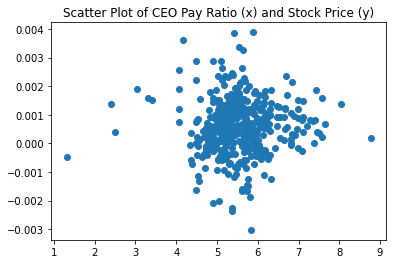

In [19]:
import matplotlib.pyplot as plt

plt.title('Scatter Plot of CEO Pay Ratio (x) and Stock Price (y)')
plt.scatter(merge4['lnPayRatio'], merge4['avg_prc'])
plt.show()

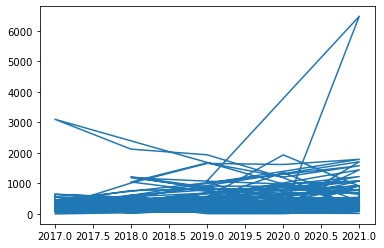

In [20]:
import numpy as np

plt.plot(merge4['FiscalYear'], merge4['PayRatio'])
plt.show()


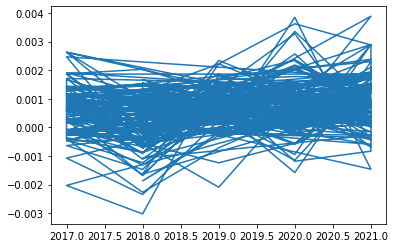

In [21]:
import numpy as np

plt.plot(merge4['FiscalYear'], merge4['avg_prc'])
plt.show()


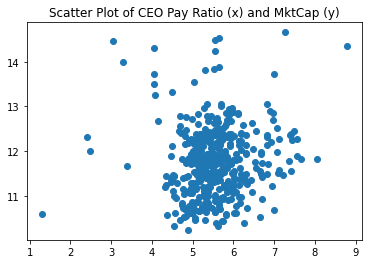

In [22]:
plt.title('Scatter Plot of CEO Pay Ratio (x) and MktCap (y)')
plt.scatter(merge4['lnPayRatio'], merge4['lnMktCap'])
plt.show()

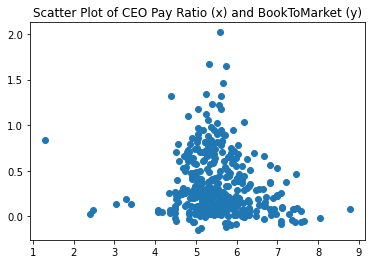

In [23]:
plt.title('Scatter Plot of CEO Pay Ratio (x) and BookToMarket (y)')
plt.scatter(merge4['lnPayRatio'], merge4['BookToMarket'])
plt.show()

In [24]:
import statsmodels.formula.api as sm
#specify the mod
mode1 = sm.ols(formula='avg_prc~lnPayRatio+lnMktCap+BookToMarket', data=merge4)
#run the model
res1 = mode1.fit()
#print out the results
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_prc   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     19.39
Date:                Sat, 19 Nov 2022   Prob (F-statistic):           8.88e-12
Time:                        20:41:51   Log-Likelihood:                 2321.7
No. Observations:                 416   AIC:                            -4635.
Df Residuals:                     412   BIC:                            -4619.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0028      0.001     -3.466      0.001      -0.004      -0.001
lnPayRatio   -2.689e-05   5.81e-05     -0.463      0.644      -0.000    8.72e-05
lnMktCap         0.0003   6.16e-05      5.095      0.000       0.000       0.000
BookToMarket    -0.0005      0.000     -3.418      0.001      -0.001      -0.000
==============================================================================
Omnibus:                       10.864   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               19.260
Skew:                           0.094   Prob(JB):                     6.57e-05
Kurtosis:                       4.037   Cond. No.                         233.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
import os 
os.getcwd()

'C:\\Users\\qingh\\Documents\\Course\\First_year\\MP5783Python\\Data_collection'

In [26]:
df = pd.DataFrame(merge4)
df.to_csv('Model2Data', index=False)